## 데이터셋이 있는 경로 문자열 만들기

In [5]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 기본 경로
base_dir = os.path.abspath('C:\박유진-텐서\CNN\dogs-vs-cats')
print(base_dir)

C:\박유진-텐서\CNN\dogs-vs-cats


In [6]:
# 훈련데이터 경로
train_dir = os.path.join(base_dir, 'train\\train')
print(train_dir)

C:\박유진-텐서\CNN\dogs-vs-cats\train\train


In [7]:
test_dir = os.path.join(base_dir, 'test1\\test1')
print(test_dir)

C:\박유진-텐서\CNN\dogs-vs-cats\test1\test1


## 훈련 데이터 내의 파일 이름을 스캔하여 정답 레이블 만들기

In [9]:
from pandas import DataFrame

# 분류 결과가 저장될 리스트
categories = []

# 훈련 데이터 폴더 내의 모든 파일목록 가져오기
filelist = os.listdir(train_dir)

for item in filelist:
    # 파일이름 형식: dog.5956.jpg, cat.5932.jpg
    # 즉 첫 번째 점 전까지의 텍스트가 카테고리임
    p = item.find('.')
    category = item[:p]
    
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
        
pd = DataFrame({'filename' : filelist, 'category' : categories})

pd

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0
...,...,...
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1


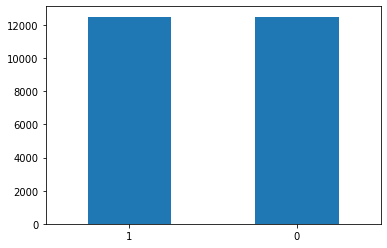

In [11]:
from matplotlib import pyplot as plt

pd['category'].value_counts().plot.bar(rot = 0)
plt.show()

## 모델 생성

In [12]:
from keras.models import Sequential
from keras.layers import *

## 배치 정규화(Batch Normalization)

- 신경망 입력 데이터를 `평균 : 0, 분산 : 1`로 정규화를 해서 학습이 잘 이루어지도록 하는 방법

![nn](KakaoTalk_20201226_155301843.png)

In [13]:
# 레이어 1

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = (128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# 레이어 2
model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# 레이어 3
model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# Fully Connected --> 1차원으로 변환하는 layer
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# 개 혹은 고양이이므로 마지막은 2개의 계측으로 나눔
model.add(Dense(2, activation = 'softmax'))

# 모델 실행 옵션
model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

## ReduceLROnPlateau

- Callback 함수의 일종
- learning rate가 더이상 업데이트가 되지 않으면 학습 중단
- plateau는 정체기란 뜻으로 모델의 정확도가 향상되지 않는 경우 --> learning rate(LR)을 줄여주는 클래스

In [14]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# patience --> 개선이 없다고 바로 종료하지 않고 개선이 없는 epoch를 얼마나 기다려 줄 것인가를 지정.
earlystop = EarlyStopping(patience = 10)

# 학습률이 개선되지 않을 때, 학습률을 동적으로 조정하여 학습률을 개선하기
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                           patience = 2,   # epoch 2동안 개선되지 않으면 callback이 호출됩니다.
                                           factor = 0.5,   # callback 호출 시 학습률을 1/2로 줄입니다.
                                           min_lr = 0.0001,
                                           verbose = 1)    # 1일 경우, EarlyStopping이 적용될 때, 화면에 적용되었다고 표시

callbacks = [earlystop, learning_rate_reduction]

## test, train 데이터 분리

In [17]:
from sklearn.model_selection import train_test_split

# 이미지 제너레이터에서 class_mode = 'categorical'로 지정하기 위해 컬럼 카테고리를 스트링으로 변경함.
pd['category'] = pd['category'].replace({0 : 'cat', 1 : 'dog'})

train_df, validate_df = train_test_split(pd, test_size = 0.3, random_state = 777)

train_df = train_df.reset_index(drop = True)
validate_df = validate_df.reset_index(drop = True)

print(train_df['category'].value_counts())
print(validate_df['category'].value_counts())

dog    8787
cat    8713
Name: category, dtype: int64
cat    3787
dog    3713
Name: category, dtype: int64


## 트레이닝 데이터의 제너레이터 설정
- 물리적인 이미지 파일들을 로드할 때 약간씩 변형을 준 후 로드하면 같은 이미지를 10번 로드하더라도 변형이 다를 경우 다른 샘플 이미지로서의 역할을 할 수 있다.

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 15

In [21]:
# 데이터 형상 관련 상수 정의
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNEL = 3

## 이미지 로드
### ImageDataGenerator 객체 생성

> 원본 이미지를 이리저리 방향 등을 바꿔 4000개의 샘플 이미지로 몇 만개의 샘플 이미지를 뽑아내는 과정

- rescale: 원래 이미지에 입력된 값만큼 이미지의 크기에 곱해서 조율함.
- rotation_range: 지정된 각도 범위에서 임의로 원본 이미지를 회전.
- width_shift_range: 지정된 수평방향 내에서 임의로 원본 이미지를 좌우로 이동.
- height_shift_range: 지정된 수직방향 내에서 임의로 원본 이미지를 상하로 이동.
- brightness_range: 이미지 밝기를 랜덤하게 주는 것.
- horizontal_flip: 수평방향으로 뒤집기
- validation_split: 주어진 데이터셋을 test와 training으로 나누는 비율.
- MNIST데이터를 사용할 경우 손글씨이기 때문에 수평반전이 일어나면 안된다!

In [28]:
train_datagen = ImageDataGenerator(rescale = 1. / 255,
                                   rotation_range = 20,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   brightness_range = [.2, .2],
                                   horizontal_flip = True)

train_generator = train_datagen.flow_from_dataframe(train_df, train_dir, x_col = 'filename', y_col = 'category',
                                                   target_size = IMAGE_SIZE, class_mode = 'categorical', batch_size = batch_size)

# 검증이미지니까 사진 그대로 쓰겠다.
validate_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = validate_datagen.flow_from_dataframe(validate_df, train_dir, x_col = 'filename', y_col = 'category',
                                                           target_size = IMAGE_SIZE, class_mode = 'categorical', batch_size = batch_size)


Found 17500 validated image filenames belonging to 2 classes.
Found 7500 validated image filenames belonging to 2 classes.


## 변형된 이미지 출력을 위한 예제 이미지들 생성

In [29]:
# 샘플데이터 확인
example_df = train_df.sample(n = 1).reset_index(drop = True)
example_df

example_generator = train_datagen.flow_from_dataframe(example_df, train_dir,
                                                     x_col = 'filename', y_col = 'category',
                                                     target_size = IMAGE_SIZE, class_mode = 'categorical')

Found 1 validated image filenames belonging to 1 classes.


## 학습

In [31]:
epochs = 3

hist = model.fit_generator(train_generator, 
                           epochs = epochs,
                           steps_per_epoch = total_train//batch_size,
                           validation_data = validation_generator,
                           validation_steps = total_validate//batch_size,
                           callbacks = callbacks)

Epoch 1/3
1166/1166 [==============================] - 1492s 1s/step - loss: 0.7447 - accuracy: 0.6306 - val_loss: 2.5433 - val_accuracy: 0.5600
Epoch 2/3
1166/1166 [==============================] - 1450s 1s/step - loss: 0.5463 - accuracy: 0.7289 - val_loss: 4.2719 - val_accuracy: 0.5985
Epoch 3/3
1166/1166 [==============================] - 1392s 1s/step - loss: 0.4953 - accuracy: 0.7658 - val_loss: 1.5596 - val_accuracy: 0.6883


## 모델 저장

In [32]:
model.save_weights('model.h5')

## 평가

In [33]:
score = model.evaluate(validation_generator, verbose = 0)
print(score)

[1.5595523118972778, 0.6882666945457458]


- 학습 결과로 리턴된 history에서 확인할 수 있는 지표 출력
- 학습 과정을 확인할 때 그래프로 표시할 수 있는 항목이 출력된다.
- 출력결과: ``` dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy']) ```

In [34]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


## 학습과정 확인하기

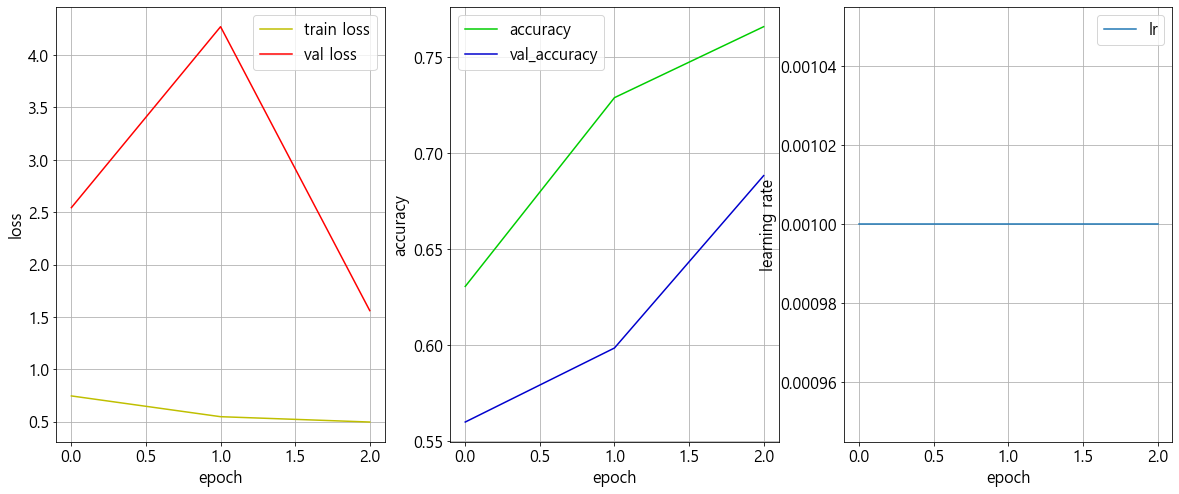

In [35]:
from matplotlib import pyplot as plt

plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['figure.figsize'] = (20, 8)

fig = plt.figure()
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.plot(hist.history['loss'], 'y', label = 'train loss')
ax1.plot(hist.history['val_loss'], 'r', label = 'val loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend(bbox_to_anchor = (1,1))

ax2.plot(hist.history['accuracy'], color = '#00cd00', label = 'accuracy')
ax2.plot(hist.history['val_accuracy'], color = '#0000cd', label = 'val_accuracy')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.grid()
ax2.legend()

ax3.plot(hist.history['lr'], label = 'lr')
ax3.set_xlabel('epoch')
ax3.set_ylabel('learning rate')
ax3.grid()
ax3.legend()

plt.show()

## 학습된 모델을 통해 값 예측하기

In [36]:
filenames = os.listdir(test_dir)

test_df = DataFrame({'filename' : filenames})
test_df

nbsamples = test_df.shape[0]

# 테스트 이미지니까, 사진 그대로 씀
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_dataframe(test_df, test_dir,
                                                 x_col = 'filename', y_col = None,
                                                 target_size = IMAGE_SIZE,
                                                 class_mode = None,
                                                 batch_size = batch_size,
                                                 shuffle = False)


Found 12500 validated image filenames.


## 예측

In [39]:
import numpy as np

predict = model.predict_generator(test_generator,
                                 steps = nbsamples/batch_size,
                                 callbacks = callbacks)

test_df['category'] = np.argmax(predict, axis = 1)

test_df['category'] = test_df['category'].replace({0 : 'cat', 1 : 'dog'})
ex_df = test_df.sample(n = 1).reset_index(drop = True)
ex_df

,filename,category
0,12466.jpg,cat


C:\박유진-텐서\CNN\dogs-vs-cats\test1\test1\12466.jpg


<function matplotlib.pyplot.show(close=None, block=None)>

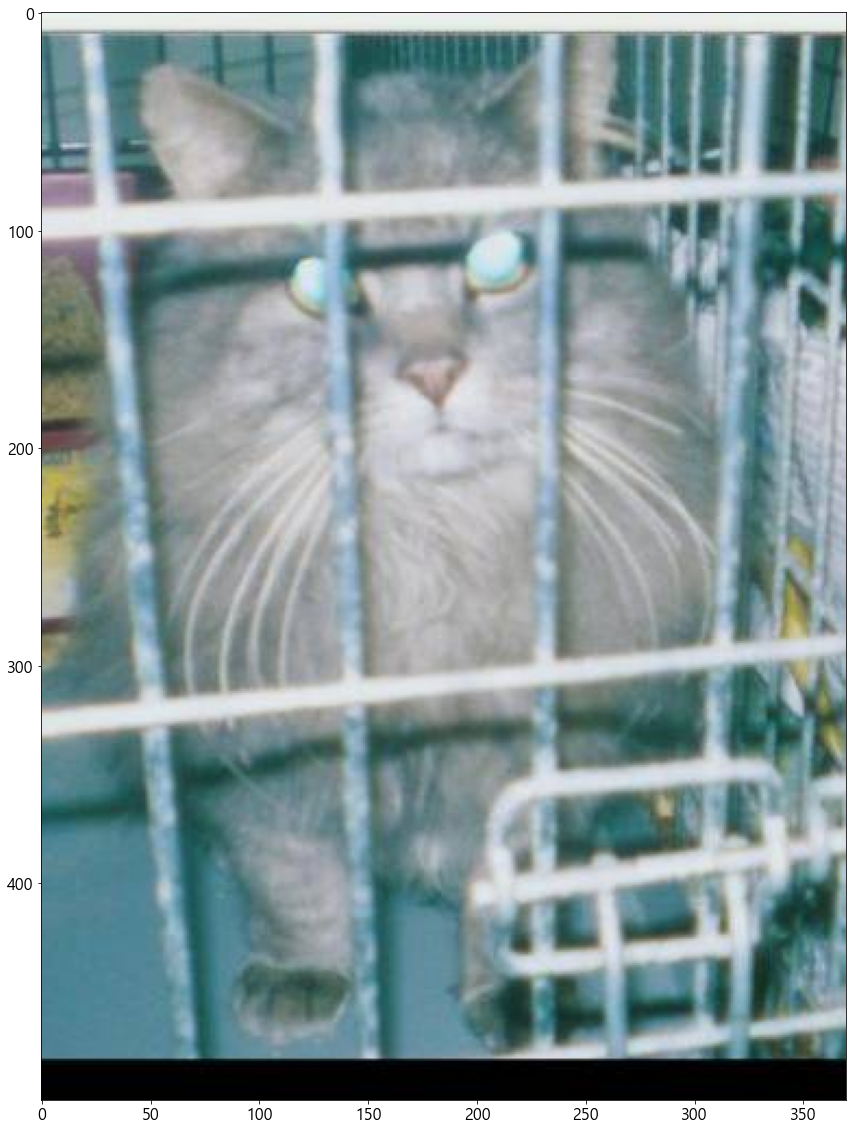

In [41]:
from keras.preprocessing.image import load_img

rnd_img_path = os.path.join(test_dir, ex_df['filename'][0])
print(rnd_img_path)

image = load_img(rnd_img_path)
plt.figure(figsize = (16, 16))
plt.imshow(image)

plt.tight_layout()
plt.show

## CNN 구현 단계

- Step1 : Convolution
- Step2 : Pooling
- Step3 : Flattening
- Step4 : Full Connection